<a href="https://colab.research.google.com/github/Anikrage/EEG-Classification-using-Self-Supervised-Diffusion-Convolutional-Graph-Neural-Network/blob/prototype/Res1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Loading Dataset

In [4]:
import pandas as pd
import numpy as np

# Load data in chunks to handle large size
chunksize = 10000  # Adjust this size as needed
file_path = '/content/drive/MyDrive/eeg_mdd_dataset/eeg_dataset.csv'

# Initialize lists to collect chunks
data_chunks = []

# Read the CSV in chunks
for chunk in pd.read_csv(file_path, chunksize=chunksize):
    # Preprocess each chunk
    chunk['Group'] = chunk['Group'].map({'H': 0, 'MDD': 1})  # Encode labels
    data_chunks.append(chunk)

# Concatenate all chunks
data = pd.concat(data_chunks, axis=0)

# Check the data
print(data.head())


     Fp1-LE     F3-LE     C3-LE     P3-LE     O1-LE     F7-LE     T3-LE  \
0 -0.000005 -0.000009 -0.000012 -0.000011 -0.000002 -0.000010 -0.000008   
1 -0.000007 -0.000012 -0.000021 -0.000017 -0.000009 -0.000015 -0.000012   
2 -0.000009 -0.000015 -0.000029 -0.000021 -0.000013 -0.000021 -0.000016   
3 -0.000008 -0.000016 -0.000033 -0.000021 -0.000015 -0.000024 -0.000022   
4 -0.000005 -0.000013 -0.000028 -0.000018 -0.000014 -0.000021 -0.000026   

      T5-LE     Fz-LE        Fp2-LE  ...         T4-LE         T6-LE  \
0 -0.000012 -0.000009 -1.310000e-05  ... -8.650000e-06 -3.350000e-06   
1 -0.000014 -0.000011 -1.400000e-05  ... -8.750000e-06 -2.650000e-06   
2 -0.000015 -0.000012 -1.130000e-05  ... -6.450000e-06 -8.500000e-07   
3 -0.000016 -0.000011 -6.250000e-06  ... -2.950000e-06  1.150000e-06   
4 -0.000016 -0.000007 -1.500000e-07  ...  2.500000e-07  2.950000e-06   

      Cz-LE     Pz-LE         A2-A1   23A-23R   24A-24R  Group  Subject ID  \
0 -0.000015 -0.000008 -2.150000e-06 -0

Artifact Removal using ICA


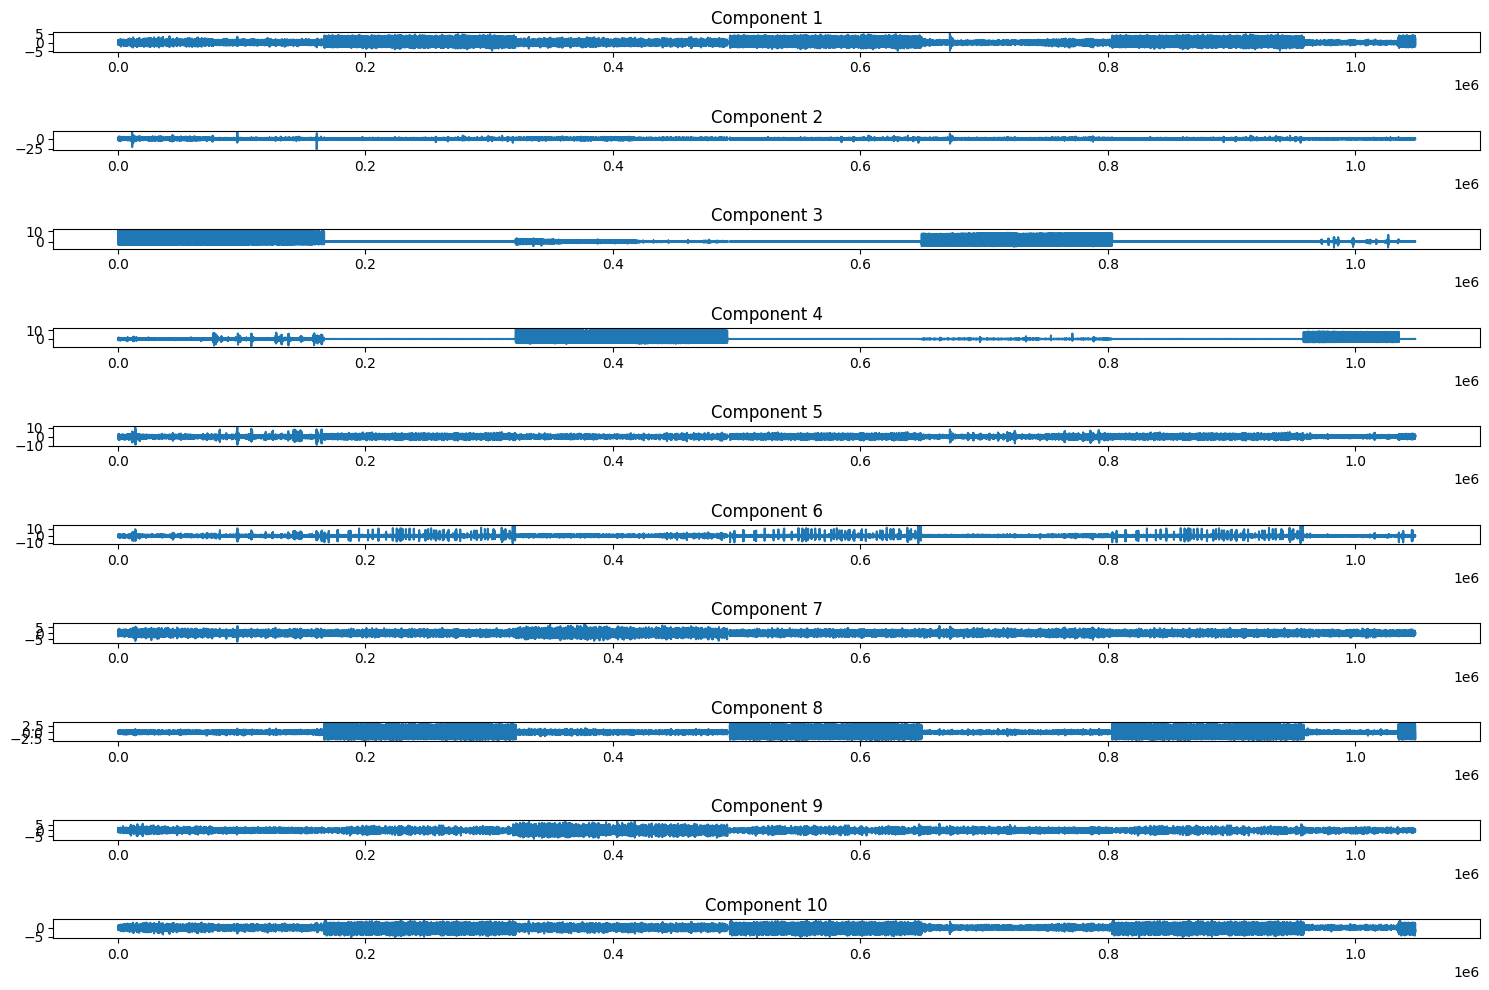

In [6]:
from sklearn.decomposition import FastICA
import numpy as np
import matplotlib.pyplot as plt

def remove_artifacts(df, n_components=10):
    eeg_data = df.iloc[:, :-3].values  # Exclude non-EEG columns
    ica = FastICA(n_components=n_components, random_state=42)
    components = ica.fit_transform(eeg_data)

    # Plot the components to visually inspect (optional)
    plt.figure(figsize=(15, 10))
    for i in range(n_components):
        plt.subplot(n_components, 1, i+1)
        plt.plot(components[:, i])
        plt.title(f'Component {i+1}')
    plt.tight_layout()
    plt.show()

    # Assume artifact components have been identified (manual or automatic process)
    # Here we use a simple thresholding for demonstration, but in practice,
    # it should involve careful analysis.
    artifact_indices = []  # Example: identify based on criteria or manual inspection

    # Remove the artifact components
    components[:, artifact_indices] = 0

    # Reconstruct the cleaned EEG signal
    cleaned_eeg_data = ica.inverse_transform(components)

    return pd.DataFrame(cleaned_eeg_data, columns=df.columns[:-3])

# Apply the artifact removal
data_cleaned = remove_artifacts(data, n_components=10)


Frequency Filtering

In [7]:
from scipy.signal import butter, lfilter

def bandpass_filter(data, lowcut=0.5, highcut=45.0, fs=128, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_data = lfilter(b, a, data, axis=0)
    return filtered_data

data_filtered = bandpass_filter(data_cleaned.values)



Segment Data into Ecpochs for each condition

In [8]:
def segment_epochs(data, epoch_length=256):  # Assuming fs = 128 Hz, 2 seconds per epoch
    num_samples = data.shape[0]
    num_epochs = num_samples // epoch_length
    epochs = data[:num_epochs * epoch_length].reshape((num_epochs, epoch_length, -1))
    return epochs

epochs = segment_epochs(data_filtered)


Feature Extraction

In [9]:
import numpy as np
from scipy.signal import welch

def extract_features(epochs):
    features = []
    for epoch in epochs:
        epoch_features = []
        for electrode_data in epoch.T:  # Iterate over each electrode's data
            f, psd = welch(electrode_data, fs=128)
            band_power = {
                'alpha': np.sum(psd[(f >= 8) & (f <= 13)]),
                'beta': np.sum(psd[(f >= 14) & (f <= 30)]),
                'theta': np.sum(psd[(f >= 4) & (f <= 7)])
            }
            epoch_features.append(band_power)
        features.append(epoch_features)
    return np.array(features)

data_features = extract_features(epochs)
